# Working with TensorFlow Serving
* This notebook is much related to my other notebooks in this same repository where I have demonstrated how to save a model using saved_model util in TensorFlow. 

## Necessary imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from mnist import mnist
import json
import requests
import subprocess

## Load data
* We need to load test data on which the prediction would be done.

In [2]:
obj = mnist()
X_train, y_train, X_test, y_test = obj.load_data()

# split into validation and test set from the test set alone
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, random_state=0)

In [3]:
print('==== Printing shapes of data ===')
print()
print('Train data:      ', X_train.shape, y_train.shape)
print('Test data:       ', X_test.shape, y_test.shape)
print('Validation data: ', X_validation.shape, y_validation.shape)

==== Printing shapes of data ===

Train data:       (60000, 32, 32, 1) (60000,)
Test data:        (7500, 32, 32, 1) (7500,)
Validation data:  (2500, 32, 32, 1) (2500,)


In [4]:
def show(idx, X_tmp, y_tmp, title):
    image = X_tmp[idx].squeeze()
    plt.figure()
    
    plt.imshow(image)
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

## Steps to start TensorFlow model server 
* Ensure the following: 
    * save model using the saved_model util as shown in [Exploring-TensorFlow-Low-Level-API.ipynb](Exploring-TensorFlow-Low-Level-API.ipynb)
    * version your saved model - make an empty directory, rename it to '1' and put the files
    obtained above in '1' - this is not an ideal way of doing things, make a script such that everytime you write a model, it writes into a new, version directory, say if you saved model again, then the script should put the new model(and other files) in folder named '2' and so on....

* The command below runs server as a background process puts logs in server.log fike:

`nohup tensorflow_model_server --rest_api_port=8501 --model_name='lenet_model' --model_base_path='/home/anuj/git/personal/github/Computer-Vision-Playground/deep-learning/exploring-tensorflow/models/mnist/lenet/using_SavedModelBuilder' > server.log 2 >&1 &` 


## Check parameter names
* This is another IMPORTANT step - it is requried to get the names of the following:
    * ## signature definition
    * input tensor name
    * ouput tensor name
    * saved model tags
    * method name
* some of these would be required ahead

In [5]:
!saved_model_cli show --dir './models/mnist/lenet/using_SavedModelBuilder/1' --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 1)
        name: input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: output:0
  Method name is: tensorflow/serving/predict


## Prepare payload - data (.json) and header
* Note: the value for signature_name is obtained only after running the above step

In [6]:
# prepare header
headers = {"content-type": "application/json"}

# prepare data
data = json.dumps({"signature_name": "predict", "instances": X_test[0:5].tolist()})

## API call to TensorFlow ModelServer
* make a post request with payload

* Note: API url: http://localhost/8501/v1/models/lenet_model:predict - here `lenet_model` is what we set using the `--model_name` flag while starting the server, and the `predict` is our __signature defination__ 

* It is a standard form for [Classify and Regress API](https://www.tensorflow.org/tfx/serving/api_rest) like: `http://host:port/v1/models/${MODEL_NAME}[/versions/${MODEL_VERSION}]:(classify|regress)`

In [7]:
# send request with payload
json_response = requests.post(
    'http://localhost:8501/v1/models/lenet_model:predict', 
    data=data, 
    headers=headers)

# get response (predictions)
predictions = json.loads(json_response.text)
# check response
print(predictions)

{'predictions': [[6.6702e-09, 2.54642e-05, 1.01885e-05, 0.00156464, 8.38854e-09, 1.18849e-07, 1.89688e-09, 0.998395, 3.94925e-06, 8.92547e-07], [1.54389e-06, 0.999719, 5.25337e-06, 6.29348e-06, 8.02695e-05, 1.4824e-07, 1.47467e-08, 1.65463e-05, 5.21459e-05, 0.00011893], [1.0, 4.52722e-12, 7.89191e-09, 1.81505e-09, 1.32284e-10, 2.22894e-10, 1.03633e-07, 1.32048e-10, 9.39479e-09, 2.9385e-07], [0.839423, 5.56748e-07, 3.56255e-06, 2.79125e-09, 0.00060202, 1.36375e-05, 0.158716, 9.80284e-06, 2.64902e-06, 0.00122877], [0.042825, 3.17963e-06, 0.000558107, 0.325579, 0.000992565, 0.0192002, 0.000795021, 6.07722e-06, 0.571185, 0.0388554]]}


## Check predictions

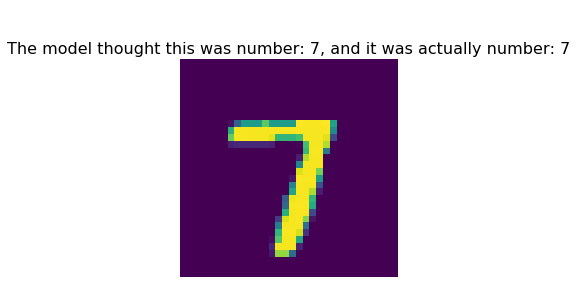

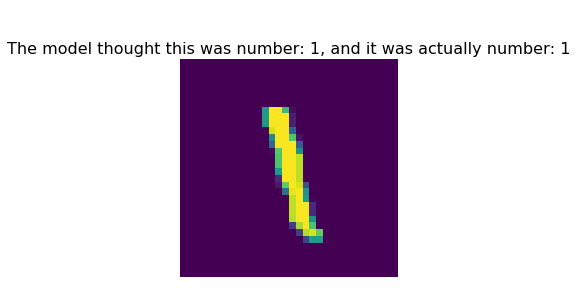

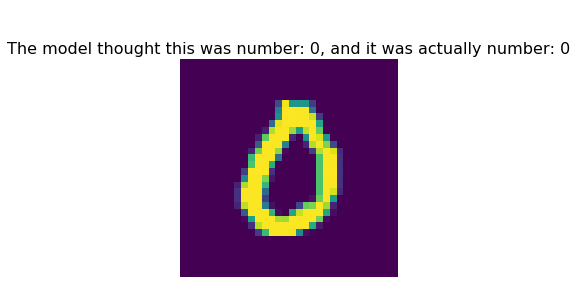

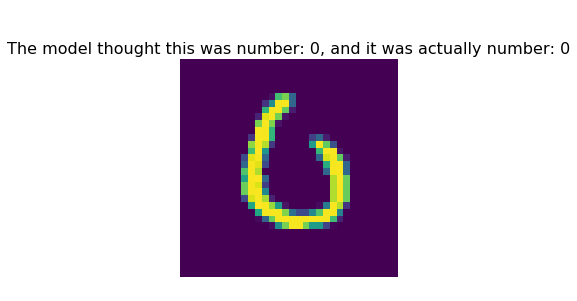

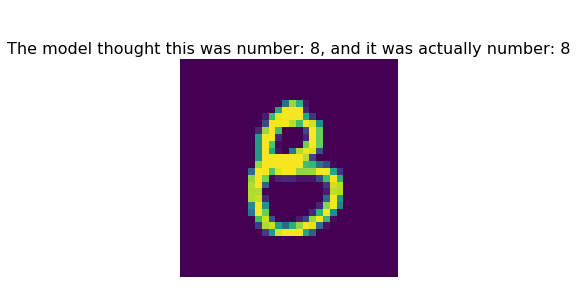

In [8]:
num_predictions = len(predictions['predictions'])
for idx, pred in enumerate(predictions['predictions']):
    y_pred = np.argmax(pred)
    show(idx, X_test, y_test, 'The model thought this was number: {}, and it was actually number: {}'.format(
        y_pred, y_test[idx]))
    
# [np.argmax(arr) for arr in predictions]
# list(map(np.argmax, predictions))

## References

* https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb
* https://medium.com/tensorflow/serving-ml-quickly-with-tensorflow-serving-and-docker-7df7094aa008
* https://medium.freecodecamp.org/how-to-deploy-tensorflow-models-to-production-using-tf-serving-4b4b78d41700
* https://sthalles.github.io/serving_tensorflow_models/